### Data Prep

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
from ipywidgets import interact

data = pd.read_csv('churn.csv')
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')
data = data[~data['TotalCharges'].isna()]

binary_mapper = {
    'No': 0,
    'Yes': 1,
}
for col in data.columns:
    if sorted(data[col].unique().tolist()) == ['No', 'Yes']:
        data[col] = data[col].map(binary_mapper)
data = data.drop(columns=['gender'])

multiline_dummies = pd.get_dummies(data['MultipleLines'], prefix='MultLines')
data = pd.concat([data, multiline_dummies], axis=1)
data = data.drop(columns=['MultipleLines', 'MultLines_No phone service'])

int_service_columns = [
    'OnlineSecurity', 
    'OnlineBackup',
    'DeviceProtection', 
    'TechSupport', 
    'StreamingTV', 
    'StreamingMovies',
]

data['num_internet_services'] = (data[int_service_columns] == 'Yes').astype(int).sum(axis=1)
data = data.drop(columns=int_service_columns)

data = data.drop(columns=['customerID'])
for col in data.columns:
    if data[col].dtype == 'object':
        dummies = pd.get_dummies(data[col], prefix=col)
        data = data.drop(columns=[col])
        data = pd.concat([data, dummies], axis=1)
data = data.drop(columns=['InternetService_No'])

col_order = [
    'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 
    'Contract_Month-to-month',
    'Contract_One year', 'Contract_Two year',
    'PaymentMethod_Bank transfer (automatic)',
    'PaymentMethod_Credit card (automatic)',
    'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check', 
    'PaperlessBilling',
    'MonthlyCharges', 'TotalCharges', 
    'PhoneService', 'MultLines_No', 'MultLines_Yes', 
    'InternetService_DSL', 'InternetService_Fiber optic', 'num_internet_services', 'Churn',
]

data = data.loc[:, col_order]
data = data.reset_index(drop=True)

data.head()

,SeniorCitizen,Partner,Dependents,tenure,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,PaperlessBilling,MonthlyCharges,TotalCharges,PhoneService,MultLines_No,MultLines_Yes,InternetService_DSL,InternetService_Fiber optic,num_internet_services,Churn
0,0,1,0,1,1,0,0,0,0,1,0,1,29.85,29.85,0,0,0,1,0,1,0
1,0,0,0,34,0,1,0,0,0,0,1,0,56.95,1889.50,1,1,0,1,0,2,0
2,0,0,0,2,1,0,0,0,0,0,1,1,53.85,108.15,1,1,0,1,0,2,1
3,0,0,0,45,0,1,0,1,0,0,0,0,42.30,1840.75,0,0,0,1,0,3,0
4,0,0,0,2,1,0,0,0,0,1,0,1,70.70,151.65,1,1,0,0,1,0,1


### Specify *target* and *feature* variables

In [2]:
target = 'Churn'

features = [col for col in data.columns if col != target]

### Helper function for plotting churn by feature column

In [3]:
def plot_churn_by_column(ccolumn):
    plot_df = data.groupby(ccolumn)['Churn'].mean()
    fig, ax =plt.subplots(1, 1, figsize=(5,3))
    if len(plot_df) > 5:
        plot_df.plot(
            kind='line',
            ax=ax,
        )
    else:
        plot_df.plot(
            kind='bar',
            edgecolor='k',
            ax=ax,
        )
    plt.show()

### Interactive Plot

In [4]:
interact(plot_churn_by_column, ccolumn=features);

interactive(children=(Dropdown(description='ccolumn', options=('SeniorCitizen', 'Partner', 'Dependents', 'tenu…

### Principal Components Analysis

pca.explained_variance_ratio_.sum() = 0.9999825924140721


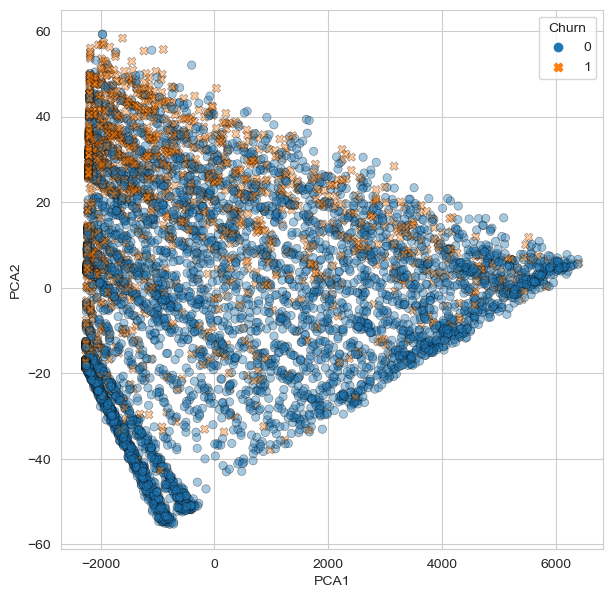

In [5]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(data[features])
print(f'{pca.explained_variance_ratio_.sum() = }')

pca_vectors = pca.transform(data[features])
pca_vectors = pd.DataFrame(pca_vectors, columns=['PCA1', 'PCA2'])
pca_vectors = pd.concat([pca_vectors, data[target]], axis=1)

fig, ax = plt.subplots(1, 1, figsize=(7, 7))

sns.scatterplot(
    x='PCA1',
    y='PCA2',
    data=pca_vectors,
    hue='Churn',
    style='Churn',
    alpha=0.4,
    edgecolor='k',
)

plt.show()

### Split data into *test* and *train* sets

In [6]:
from sklearn.model_selection import train_test_split

X = data[features].copy()
y = data[target].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

### Decision Tree (Case 1 - Overfitting)

In [7]:
from sklearn import tree

clf = tree.DecisionTreeClassifier(random_state=0)
clf = clf.fit(X_train, y_train)
clf.score(X_train, y_train)

0.997535077739856

In [8]:
clf.score(X_test, y_test)

0.729806598407281

### Decision Tree (Case 2 - Not Overfitting)

In [14]:
from tqdm import tqdm

In [18]:
from sklearn import tree

#for i in tqdm(range(50), 'Running experiment'):
clf = tree.DecisionTreeClassifier(random_state=0, max_depth=3)
clf = clf.fit(X_train, y_train)
clf.score(X_train, y_train)

0.7914296549108836

In [19]:
clf.score(X_test, y_test)

0.7889647326507395

In [20]:
print(tree.export_text(clf, feature_names=features))

|--- Contract_Month-to-month <= 0.50
|   |--- MonthlyCharges <= 93.67
|   |   |--- Contract_Two year <= 0.50
|   |   |   |--- class: 0
|   |   |--- Contract_Two year >  0.50
|   |   |   |--- class: 0
|   |--- MonthlyCharges >  93.67
|   |   |--- TotalCharges <= 6586.10
|   |   |   |--- class: 0
|   |   |--- TotalCharges >  6586.10
|   |   |   |--- class: 0
|--- Contract_Month-to-month >  0.50
|   |--- InternetService_Fiber optic <= 0.50
|   |   |--- tenure <= 3.50
|   |   |   |--- class: 0
|   |   |--- tenure >  3.50
|   |   |   |--- class: 0
|   |--- InternetService_Fiber optic >  0.50
|   |   |--- tenure <= 15.50
|   |   |   |--- class: 1
|   |   |--- tenure >  15.50
|   |   |   |--- class: 0



### Random Forest

In [12]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(random_state=0, max_depth=3)
clf = clf.fit(X_train, y_train)
clf.score(X_train, y_train)

0.7929465301478953

In [13]:
clf.score(X_test, y_test)

0.7844141069397043

## GridSearch

In [22]:
from sklearn.model_selection import GridSearchCV

In [23]:
dt = tree.DecisionTreeClassifier()
parameters = {'criterion': ("gini", "entropy", "log_loss"),
              'splitter': ('best', 'random'),
              'max_depth': [1,2,3,4,5]}

clf = GridSearchCV(dt, parameters)
clf.fit(X_train, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ('gini', 'entropy', 'log_loss'),
                         'max_depth': [1, 2, 3, 4, 5],
                         'splitter': ('best', 'random')})

In [28]:
pd.DataFrame().from_dict(clf.cv_results_).sort_values('mean_test_score', ascending=False).head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_splitter,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
28,0.011558,0.000480,0.001198,0.000399,log_loss,5,best,"{'criterion': 'log_loss', 'max_depth': 5, 'spl...",0.813270,0.781991,0.801896,0.788626,0.812144,0.799585,0.012490,1
18,0.010188,0.000385,0.001577,0.000475,entropy,5,best,"{'criterion': 'entropy', 'max_depth': 5, 'spli...",0.812322,0.781991,0.801896,0.788626,0.812144,0.799396,0.012287,2
8,0.009174,0.000396,0.001198,0.000390,gini,5,best,"{'criterion': 'gini', 'max_depth': 5, 'splitte...",0.811374,0.779147,0.799052,0.783886,0.811195,0.796931,0.013439,3


In [29]:
clf.best_params_

{'criterion': 'log_loss', 'max_depth': 5, 'splitter': 'best'}

In [30]:
dt_best = tree.DecisionTreeClassifier(**clf.best_params_)

In [31]:
dt_best.fit(X_test, y_test)
dt_best.score(X_test, y_test)

0.7997724687144482

In [36]:
rf = RandomForestClassifier()
parameters = {'n_estimators': (50, 100, 250),
              'criterion': ["gini", "entropy", "log_loss"],
              'max_depth': [1,2,3,4,5]}

clf = GridSearchCV(rf, parameters, n_jobs=-1)
clf.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [1, 2, 3, 4, 5],
                         'n_estimators': (50, 100, 250)})

In [37]:
clf.best_params_

{'criterion': 'gini', 'max_depth': 5, 'n_estimators': 50}

In [38]:
clf.best_score_

0.8022410676547029